# Characterization of corpus callosum DWI using autoencoder

## Abstract

Corpus Callosum (CC) is a subcortical, white matter structure with great importance in clinical and research studies because its shape and volume are correlated with subject's characteristics and neurodegenerative diseases. CC segmentation is a important step for any medical, clinical or research posterior study. Currently, magnetic resonance imaging (MRI) is the main tool for evaluating brain because it offers the better soft tissue contrast. Particullary, segmentation in MRI difussion modality has great importante given information associated to brain microstruture and fiber composition.

In this work a method for characterization of the CC using a autoencoder (AE) is proposed.

In [1]:
import sys,os, copy, sqlite3, platform, re
main_path = '/home/wilomaku/Repositories/functions/'
paths = [os.path.abspath(main_path), os.path.abspath('{}dtimp'.format(main_path))]
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

import numpy as np
import dtimp as DTI
import scipy as scipy
import scipy.misc as misc 
import nibabel as ni
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import genfromtxt

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms
%matplotlib inline

print("Python version: ", platform.python_version())
print("Numpy version: ", np.version.version)
print("Scipy version: ", scipy.__version__)
print("Matplotlib version: ", mpl.__version__)
print("Pytorch version: ", torch.__version__)

/home/wilomaku/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


Python version:  3.6.3
Numpy version:  1.13.3
Scipy version:  0.19.1
Matplotlib version:  2.1.0
Pytorch version:  0.2.0_4


# Creating dataloader

In [2]:
class MRIDataset(Dataset):
    
    def __init__(self, root_dir, n_slice=-1, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            n_slice (int): Slice number. If -1, mid slice is passed.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.n_slice = n_slice
        self.transform = transform

    def __len__(self):
        return len(next(os.walk(self.root_dir))[1])

    def __getitem__(self, idx):
        base_path = '{}{:06.0f}/'.format(self.root_dir,idx+1)
        file_DTI = '{}diffusion.nii.gz'.format(base_path)
        vol_dti = ni.load(file_DTI).get_data()
        
        if self.n_slice == -1:
            slice_ch = int(vol_dti.shape[0]/2)
            vol_2d = vol_dti[slice_ch]
        else:
            vol_2d = vol_dti[self.n_slice]
        
        if self.transform:
            vol_2d = self.transform(vol_2d)

        return vol_2d

class ToTensor(object):
    """Numpy-arrays to Tensors."""
    def __call__(self, sample):
        image = sample.swapaxes(0,-1)
        return torch.Tensor(image).type(torch.FloatTensor)

class ToNormalize(object):
    """Normalization between 0 and 1."""
    def __call__(self, sample):
        return sample/torch.max(sample)
    
class ToCrop(object):
    """Crop image to CC region."""
    def __call__(self, sample):
        return sample[:,10:-10,60:-60]

In [101]:
class MRIDataset_list(Dataset):
    
    def __init__(self, list_dirs, n_slice=-1, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            n_slice (int): Slice number. If -1, mid slice is passed.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_dirs = list_dirs
        self.n_slice = n_slice
        self.transform = transform

    def __len__(self):
        return len(self.list_dirs)

    def __getitem__(self, idx):
        base_path = '{}/'.format(self.list_dirs[idx])
        file_DTI = '{}diffusion.nii.gz'.format(base_path)
        vol_dti = ni.load(file_DTI).get_data()
        
        if self.n_slice == -1:
            slice_ch = int(vol_dti.shape[0]/2)
            vol_2d = vol_dti[slice_ch]
        else:
            vol_2d = vol_dti[self.n_slice]
        
        if self.transform:
            vol_2d = self.transform(vol_2d)

        return vol_2d

In [4]:
grad_ch = 0
n_samples_ini = len(list_gender)

transformed_dataset = MRIDataset(root_dir=base_path, transform=transforms.Compose([ToTensor(), ToNormalize(), ToCrop()]))
fig = plt.figure(figsize=(15,8))
indices = np.array(range(n_samples_ini))
#ind_indices = np.ones((n_samples_ini)).astype('bool')
#ind_indices[[37, 77, 90, 101, 104, 122, 128, 129, 130, 143, 201]] = False
#indices = list(indices[ind_indices])
n_samples = len(indices)
print('New dataset size (Leaving out sized-different subjects): ', n_samples)
for i in indices:
    sample = transformed_dataset[i]
    print(i+1,sample.size(),torch.max(sample))
    #ax = plt.subplot(3, 3, i+1)
    #plt.tight_layout()
    #ax.set_title('Sample #{}'.format(i))
    #ax.axis('off')
    #plt.imshow(sample.numpy()[grad_ch],cmap='gray')
    #if i == 8:
    #    plt.show()
    #    break
#plt.show()

Cin = transformed_dataset[i].numpy().shape[0] #Input Channels

New dataset size (Leaving out sized-different subjects):  202
1 torch.Size([33, 50, 136]) 1.0
2 torch.Size([33, 50, 136]) 1.0
3 torch.Size([33, 50, 136]) 1.0
4 torch.Size([33, 50, 136]) 0.8998849391937256
5 torch.Size([33, 50, 136]) 0.8666666150093079
6 torch.Size([33, 50, 136]) 1.0
7 torch.Size([33, 50, 136]) 1.0
8 torch.Size([33, 50, 136]) 0.9254237413406372
9 torch.Size([33, 50, 136]) 1.0
10 torch.Size([33, 50, 136]) 1.0
11 torch.Size([33, 50, 136]) 1.0
12 torch.Size([33, 50, 136]) 0.6513292193412781
13 torch.Size([33, 50, 136]) 1.0
14 torch.Size([33, 50, 136]) 0.8157894611358643
15 torch.Size([33, 50, 136]) 0.5910041928291321
16 torch.Size([33, 50, 136]) 1.0
17 torch.Size([33, 50, 136]) 1.0
18 torch.Size([33, 50, 136]) 0.8858746290206909
19 torch.Size([33, 50, 136]) 1.0
20 torch.Size([33, 50, 136]) 1.0
21 torch.Size([33, 50, 136]) 1.0
22 torch.Size([33, 50, 136]) 0.9345794320106506
23 torch.Size([33, 50, 136]) 1.0
24 torch.Size([33, 50, 136]) 0.9404352307319641
25 torch.Size([33, 5

In [5]:
#dataloader = DataLoader(transformed_dataset, batch_size=2, shuffle=True)
split = 16 #Number of elements in test set
test_idx = np.random.choice(np.array(indices), size=split, replace=False)
train_idx = list(set(indices) - set(test_idx))

#print(test_idx)
#print(train_idx)

train_sampler = sampler.SubsetRandomSampler(train_idx)
test_sampler = sampler.SubsetRandomSampler(test_idx)

train_loader = DataLoader(transformed_dataset, batch_size=16, shuffle=False, sampler=train_sampler)
test_loader = DataLoader(transformed_dataset, batch_size=16, shuffle=False, sampler=test_sampler)
print('====== Train Dataloader ======')
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched.size())
print('====== Test Dataloader ======')
for i_batch, sample_batched in enumerate(test_loader):
    print(i_batch, sample_batched.size())

====== Train Dataloader ======
0 torch.Size([16, 33, 50, 136])
1 torch.Size([16, 33, 50, 136])
2 torch.Size([16, 33, 50, 136])
3 torch.Size([16, 33, 50, 136])
4 torch.Size([16, 33, 50, 136])
5 torch.Size([16, 33, 50, 136])
6 torch.Size([16, 33, 50, 136])
7 torch.Size([16, 33, 50, 136])
8 torch.Size([16, 33, 50, 136])
9 torch.Size([16, 33, 50, 136])
10 torch.Size([15, 33, 50, 136])
====== Test Dataloader ======
0 torch.Size([16, 33, 50, 136])
1 torch.Size([11, 33, 50, 136])


# Autoencoder

In [6]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(Cin, 64, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.mpool1 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.mpool2 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1)
        self.mpool3 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.mpool4 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.fc_c5 = nn.Linear(32*2*7,3)
        # == Decodification ==
        self.fc_d5 = nn.Linear(3,32*2*7)
        self.deconv4 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=(0,1))
        self.mupool4 = nn.MaxUnpool2d(kernel_size=2, stride=1)
        self.deconv3 = nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.mupool3 = nn.MaxUnpool2d(kernel_size=2, stride=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1,0))
        self.mupool2 = nn.MaxUnpool2d(kernel_size=2, stride=1)
        self.deconv1 = nn.ConvTranspose2d(64, Cin, kernel_size=3, stride=2, padding=1, output_padding=(1,1))
        self.mupool1 = nn.MaxUnpool2d(kernel_size=2, stride=1)

    def encode(self, x):
        h1, self.ind1 = self.mpool1(self.relu(self.conv1(x)))
        h2, self.ind2 = self.mpool2(self.relu(self.conv2(h1)))
        h3, self.ind3 = self.mpool3(self.relu(self.conv3(h2)))
        h4, self.ind4 = self.mpool4(self.relu(self.conv4(h3)))
        return self.fc_c5(h4.view(-1, 32*2*7))

    def decode(self, y):
        i5 = self.fc_d5(y)
        i4 = self.relu(self.deconv4(self.mupool4(i5.view(-1, 32, 2, 7), self.ind4)))
        i3 = self.relu(self.deconv3(self.mupool3(i4, self.ind3)))
        i2 = self.relu(self.deconv2(self.mupool2(i3, self.ind2)))
        return self.relu(self.deconv1(self.mupool1(i2, self.ind1)))

    def forward(self, x):
        y = self.encode(x)
        return self.decode(y), y

In [7]:
net = autoencoder()
print(net)

autoencoder (
  (conv1): Conv2d(33, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU ()
  (mpool1): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mpool2): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mpool3): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mpool4): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (fc_c5): Linear (448 -> 3)
  (fc_d5): Linear (3 -> 448)
  (deconv4): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(0, 1))
  (mupool4): MaxUnpool2d (size=(2, 2), stride=(1, 1), padding=(0, 0))
  (deconv3): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mupool3): MaxUnpool2d (size=(2, 2), stride=(1, 1), padd

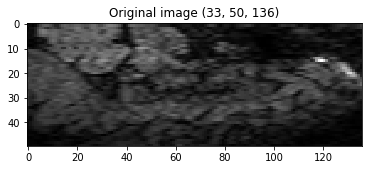

Decod >  torch.Size([16, 33, 50, 136]) Encod >  torch.Size([16, 3])


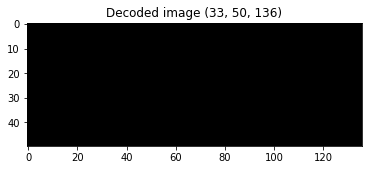

In [8]:
grad_ch = 15
for n_i, sample_batched in enumerate(test_loader):
    or_out = sample_batched.numpy()[0]
    plt.imshow(or_out[grad_ch,:,:], cmap = 'gray')
    plt.title('Original image %s'%str(or_out.shape))
    plt.show()
    #######################################################
    dec_out, enc_out = net(Variable(sample_batched))
    print('Decod > ', dec_out.size(), 'Encod > ', enc_out.size())
    pred_out = dec_out.data.numpy()[0]
    plt.imshow(pred_out[grad_ch,:,:], cmap = 'gray')
    plt.title('Decoded image %s'%str(pred_out.shape))
    plt.show()
    if n_i == 0:
        break

# Training autoencoder

In [9]:
def train(model,train_loader,valid_loader,loss_fn,optimizer,epochs=10,num_break=5,patience=5,criteria_stop="loss"):
    hist_train_loss = hist_val_loss = hist_train_acc = hist_val_acc = np.array([])
    best_epoch = patience_count = 0

    print("Training starts along %i epoch"%epochs)
    for e in range(epochs):
        correct_train = correct_val = total_train = total_val = 0
        cont_i = loss_t_e = loss_v_e = 0
        for data_train, data_valid in zip(train_loader, valid_loader):
            #if cont_i == num_break:
            #    break

            inputs = data_train
            var_inputs = Variable(inputs)

            predict, encode = model(var_inputs)
            loss = loss_fn(predict, var_inputs)
            loss_t_e += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ##Validating model
            inputs = data_valid
            var_inputs = Variable(inputs)
            predict, encode = model(var_inputs)
            loss_val = loss_fn(predict, var_inputs)
            loss_v_e += loss_val.data[0]

            cont_i += 1

        #Stacking historical
        hist_train_loss = np.hstack((hist_train_loss, loss_t_e/(cont_i*1.0)))
        hist_val_loss = np.hstack((hist_val_loss, loss_v_e/(cont_i*1.0)))
        #if e%10 == 0:
        print('Epoch: ', e, 'train loss: ', hist_train_loss[-1], 'valid loss: ', hist_val_loss[-1])

        #Early stopping by best accuracy or best loss
        if(criteria_stop == "acc"):
            if(hist_val_acc[best_epoch] < hist_val_acc[-1]):
                patience_count = 0
                best_epoch = e
                best_model = copy.copy(model)
        else:
            if(hist_val_loss[best_epoch] > hist_val_loss[-1]):
                patience_count = 0
                best_epoch = e
                best_model = copy.copy(model)

        if(patience_count > patience):
            print("Early stopped")
            break;

        if(e == epochs-1):
            print("Training stopped")
        patience_count += 1

    return(best_model, hist_train_loss, hist_val_loss)

In [10]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
epochs = 30
patience = 5
max_batch = 16
criteria = "loss"

best_model, loss, loss_test = train(net, train_loader, test_loader, loss_fn, optimizer, epochs = epochs, 
                                     num_break = max_batch, patience = patience, criteria_stop = criteria)

Training starts along 30 epoch
Epoch:  0 train loss:  0.0026716850698 valid loss:  0.00316757429391
Epoch:  1 train loss:  0.00306502718013 valid loss:  0.00306704582181
Epoch:  2 train loss:  0.00268348166719 valid loss:  0.00286092434544
Epoch:  3 train loss:  0.00243915931787 valid loss:  0.00273494538851
Epoch:  4 train loss:  0.00279685913119 valid loss:  0.0025439329911
Epoch:  5 train loss:  0.00258287251927 valid loss:  0.0022811787203
Epoch:  6 train loss:  0.00210656679701 valid loss:  0.00217524438631
Epoch:  7 train loss:  0.00221750244964 valid loss:  0.00208475720137
Epoch:  8 train loss:  0.00202638562769 valid loss:  0.00197137886425
Epoch:  9 train loss:  0.00212127726991 valid loss:  0.00187479477609
Epoch:  10 train loss:  0.00188372976845 valid loss:  0.00179629295599
Epoch:  11 train loss:  0.00168933032546 valid loss:  0.0016817660653
Epoch:  12 train loss:  0.00150159106124 valid loss:  0.00165522063617
Epoch:  13 train loss:  0.00156080693705 valid loss:  0.0015

# Testing model

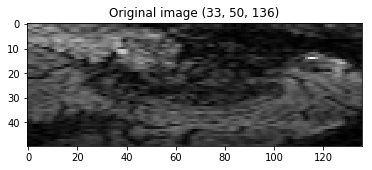

Decod >  torch.Size([16, 33, 50, 136]) Encod >  torch.Size([16, 3])


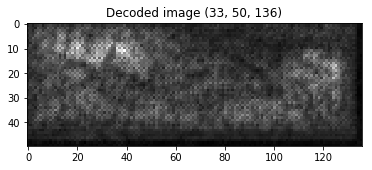

In [11]:
for n_i, sample_batched in enumerate(test_loader):
    or_out = sample_batched.numpy()[0]
    plt.imshow(or_out[grad_ch,:,:], cmap = 'gray')
    plt.title('Original image %s'%str(or_out.shape))
    plt.show()
    #######################################################
    dec_out, enc_out = best_model(Variable(sample_batched))
    print('Decod > ', dec_out.size(), 'Encod > ', enc_out.size())
    pred_out = dec_out.data.numpy()[0]
    plt.imshow(pred_out[grad_ch,:,:], cmap = 'gray')
    plt.title('Decoded image %s'%str(pred_out.shape))
    plt.show()
    if n_i == 0:
        break

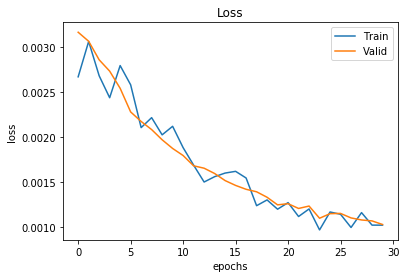

In [12]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(loss, label='Train')
plt.plot(loss_test, label='Valid')
plt.legend()
plt.show()

In [13]:
test_loader_all = next(iter(DataLoader(transformed_dataset, batch_size=n_samples)))

__, enc_out = best_model(Variable(test_loader_all))
print('Encod > ', enc_out.size())

Encod >  torch.Size([202, 3])


## Gender distribution

202
['F' 'M']
M:  42 F:  160


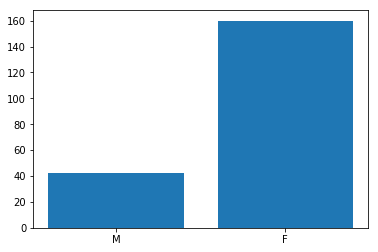

In [3]:
input_path = '/home/wilomaku/Documents/study_char/'
base_path = '{}anom/'.format(input_path)
db_anon = '{}mod_preprocess_2.sqlite3'.format(input_path)

anon = sqlite3.connect(db_anon)
anon_cur = anon.cursor()

sql = "SELECT sex FROM anon_modalities INNER JOIN anon_preprocess ON anon_preprocess.id = anon_modalities.id"
anon_cur.execute(sql)
anon_con_cur = anon_cur.fetchall()
list_gender = np.asarray(anon_con_cur).flatten()
anon_cur.close()
anon.close()
print(len(list_gender))
print(np.unique(list_gender))
print('M: ',np.sum(list_gender=='M'),'F: ',np.sum(list_gender=='F'))
plt.bar(np.arange(len(np.unique(list_gender))),[np.sum(list_gender=='M'), np.sum(list_gender=='F')])
plt.xticks(np.arange(len(np.unique(list_gender))), np.unique(list_gender)[::-1])
plt.show()

In [21]:
list_gen_bool = (list_gender == 'M').astype('uint8')
print(list_gen_bool)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0]


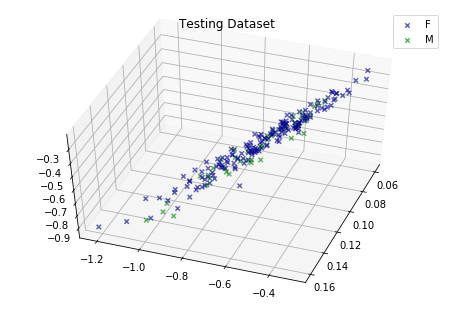

In [25]:
#colors = ['darkblue','darkblue','green','green','orange','orange']
colors = ['darkblue','green']
#labels = ['W_c','W_e','R_c','R_e','P_c','P_e']
labels = ['F','M']
#markers = ['o','x','o','x','o','x']
markers = ['x','x']
#alphas = [0.4,1,0.4,1,0.4,1]
alphas = [0.6,0.6]
Y_train = np.ones((202)).astype('uint8')
Y_train = list_gen_bool

def plot_scatter(spoints, y, label):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title(label)
    px = spoints[:,0]
    py = spoints[:,1]
    pz = spoints[:,2]
    unique = list(set(y))
    for i, u in enumerate(unique):
        xi = [px[j] for j  in range(len(px)) if y[j] == u]
        yi = [py[j] for j  in range(len(px)) if y[j] == u]
        zi = [pz[j] for j  in range(len(px)) if y[j] == u]
        ax.scatter(xi, yi, zi, c=colors[i], marker=markers[u], label=labels[u], alpha=alphas[u])
    ax.view_init(elev=50., azim=20.)
    plt.legend()
    plt.show()
plot_scatter(enc_out.data.numpy(), Y_train, 'Testing Dataset')

## Age distribution

202
[19 11 24 19 14 12 26 18 21 23 27 19 27 17 25 15 44 23 24 22 17 25 31 18 19
 30 12 23 24 25 20 21 29 22 28 25 14 32 14 35 19 19 42 25 24 25 19 33 14 27
 26 19 26 15 11 33 28 28 26 22 16 27 21 28 26 15 12 29 16 22 31 14 25 26 14
 24 29 21 27 26 15 17 26 30 22 33 22 26 20 17 23 17 33 15 21 18 32 21 30 16
 24 26 23 16 21 21 17 15 26 18 30 23 23 21 13 26 27 28 17 25 24 34 23 17 46
 28 25 15 27 30 27 32 29 24 23 24 26 31 20 23 30 23 27 25 23 22 25 30 20 14
 22 29 22 13 24 13 22 27 14 23 22 24 30 17 29 28 67 20  8 19 29 37 24 23 17
 25 24 32 28 29 27 28 21 23 28 26 29 27 28 29 30 30 21 28 22 15 21 27 29 16
 23 27]
Max:  67 Min:  8


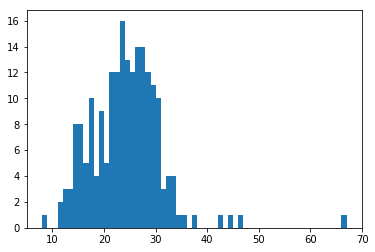

In [45]:
input_path = '/home/wilomaku/Documents/study_char/'
base_path = '{}anom/'.format(input_path)
db_anon = '{}mod_preprocess_2.sqlite3'.format(input_path)

anon = sqlite3.connect(db_anon)
anon_cur = anon.cursor()

sql = "SELECT age FROM anon_modalities INNER JOIN anon_preprocess ON anon_preprocess.id = anon_modalities.id"
anon_cur.execute(sql)
anon_con_cur = anon_cur.fetchall()
list_ages = np.asarray(anon_con_cur).flatten()
anon_cur.close()
anon.close()
print(len(list_ages))
print(list_ages)
print('Max: ',np.max(list_ages),'Min: ',np.min(list_ages))
plt.hist(list_ages, 59)
plt.show()

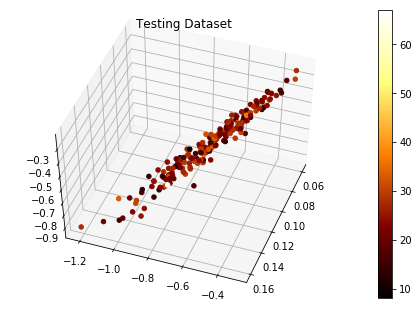

In [44]:
def plot_scatter(spoints, y, label):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title(label)
    px = spoints[:,0]
    py = spoints[:,1]
    pz = spoints[:,2]
    p = ax.scatter(px, py, pz, c=list_ages, alpha=1, cmap='afmhot')
    ax.view_init(elev=50., azim=20.)
    plt.colorbar(p)
    plt.show()
plot_scatter(enc_out.data.numpy(), Y_train, 'Testing Dataset')

## Lupus vs control distribution

189


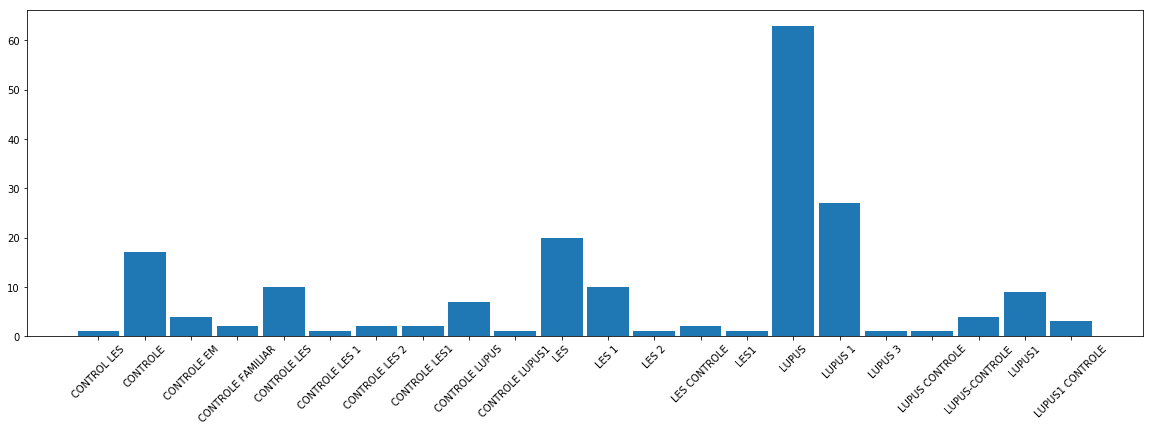

['CONTROL' 'LUPUS']
CONTROL:  57 LUPUS:  132


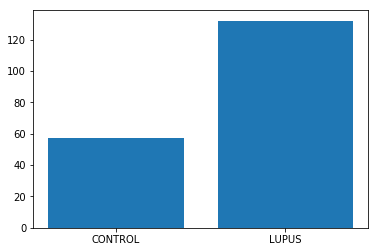

In [87]:
input_path = '/home/wilomaku/Documents/study_char/'
base_path = '{}anom/'.format(input_path)
db_anon = '{}mod_preprocess_2.sqlite3'.format(input_path)

anon = sqlite3.connect(db_anon)
anon_cur = anon.cursor()

sql = "SELECT study_1 FROM anon_modalities INNER JOIN anon_preprocess ON anon_preprocess.id = anon_modalities.id \
       AND %s != 'CRANIO' AND %s != 'CONTROLE MACHADO JOSEPH' AND %s != 'CONTROLE MACHADO' AND %s != 'ENCEFALO ROTINA' \
       AND %s != 'EPILEPSIA' AND %s != 'CONTROLE EPI'" %('study_1','study_1','study_1','study_1','study_1','study_1')
anon_cur.execute(sql)
anon_con_cur = anon_cur.fetchall()
list_type = np.asarray(anon_con_cur).flatten()
anon_cur.close()
anon.close()
print(len(list_type))
#print(list_type)

n_types = []
for type_suj in np.unique(list_type):
    n_type = np.sum(list_type == type_suj)
    n_types.append(n_type)
#print(n_types)
plt.figure(figsize=(20,6))
plt.bar(np.arange(len(n_types)),n_types, width=0.9)
plt.xticks(np.arange(len(n_types)), np.unique(list_type), rotation=45)
plt.show()

r = re.compile(r'CONTROL.')
for i,type_word in enumerate(list_type):
    if r.search(type_word) != None:
        list_type[i] = 'CONTROL'
    else:
        list_type[i] = 'LUPUS'
#print(list_type)

#print(len(np.unique(list_type)))
print(np.unique(list_type))
print('CONTROL: ',np.sum(list_type=='CONTROL'),'LUPUS: ',np.sum(list_type=='LUPUS'))

plt.bar(np.arange(len(np.unique(list_type))),[np.sum(list_type=='CONTROL'), np.sum(list_type=='LUPUS')])
plt.xticks(np.arange(len(np.unique(list_type))), np.unique(list_type))
plt.show()

In [102]:
base_path = '{}anom/'.format(input_path)
db_anon = '{}mod_preprocess_2.sqlite3'.format(input_path)

anon = sqlite3.connect(db_anon)
anon_cur = anon.cursor()

sql = "SELECT acq_folder FROM anon_modalities INNER JOIN anon_preprocess ON anon_preprocess.id = anon_modalities.id \
       AND %s != 'CRANIO' AND %s != 'CONTROLE MACHADO JOSEPH' AND %s != 'CONTROLE MACHADO' AND %s != 'ENCEFALO ROTINA' \
       AND %s != 'EPILEPSIA' AND %s != 'CONTROLE EPI'" %('study_1','study_1','study_1','study_1','study_1','study_1')
anon_cur.execute(sql)
anon_con_cur = anon_cur.fetchall()
dirs_type = np.asarray(anon_con_cur).flatten()
anon_cur.close()
anon.close()

sel_folders = [os.path.join(base_path,x) for x in dirs_type]
transformed_dataset = MRIDataset_list(list_dirs=sel_folders, transform=transforms.Compose([ToTensor(), ToNormalize(), ToCrop()]))
test_loader_all = next(iter(DataLoader(transformed_dataset, batch_size=n_samples)))

In [103]:
__, enc_out = best_model(Variable(test_loader_all))
print('Encod > ', enc_out.size())

Encod >  torch.Size([189, 3])


In [105]:
list_type_bool = (list_type == 'LUPUS').astype('uint8')
print(list_type_bool)
print('LUPUS (1): ',np.sum(list_type_bool==1),'CONTROL (0): ',np.sum(list_type_bool==0))

[1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0
 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1
 0 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1
 0 1 0 1]
LUPUS (1):  132 CONTROL (0):  57


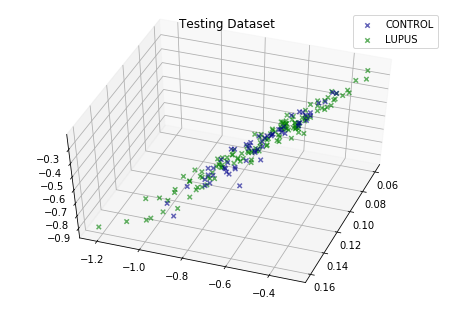

In [106]:
colors = ['darkblue','green']
labels = ['CONTROL','LUPUS']
markers = ['x','x']
alphas = [0.6,0.6]
Y_train = list_type_bool

def plot_scatter(spoints, y, label):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title(label)
    px = spoints[:,0]
    py = spoints[:,1]
    pz = spoints[:,2]
    unique = list(set(y))
    for i, u in enumerate(unique):
        xi = [px[j] for j  in range(len(px)) if y[j] == u]
        yi = [py[j] for j  in range(len(px)) if y[j] == u]
        zi = [pz[j] for j  in range(len(px)) if y[j] == u]
        ax.scatter(xi, yi, zi, c=colors[i], marker=markers[u], label=labels[u], alpha=alphas[u])
    ax.view_init(elev=50., azim=20.)
    plt.legend()
    plt.show()
plot_scatter(enc_out.data.numpy(), Y_train, 'Testing Dataset')